In [1]:
import pandas as pd
import os

In [2]:
HOUSING_PATH = os.path.join("datasets", "housing")

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data(HOUSING_PATH)
#different type of categorical values
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

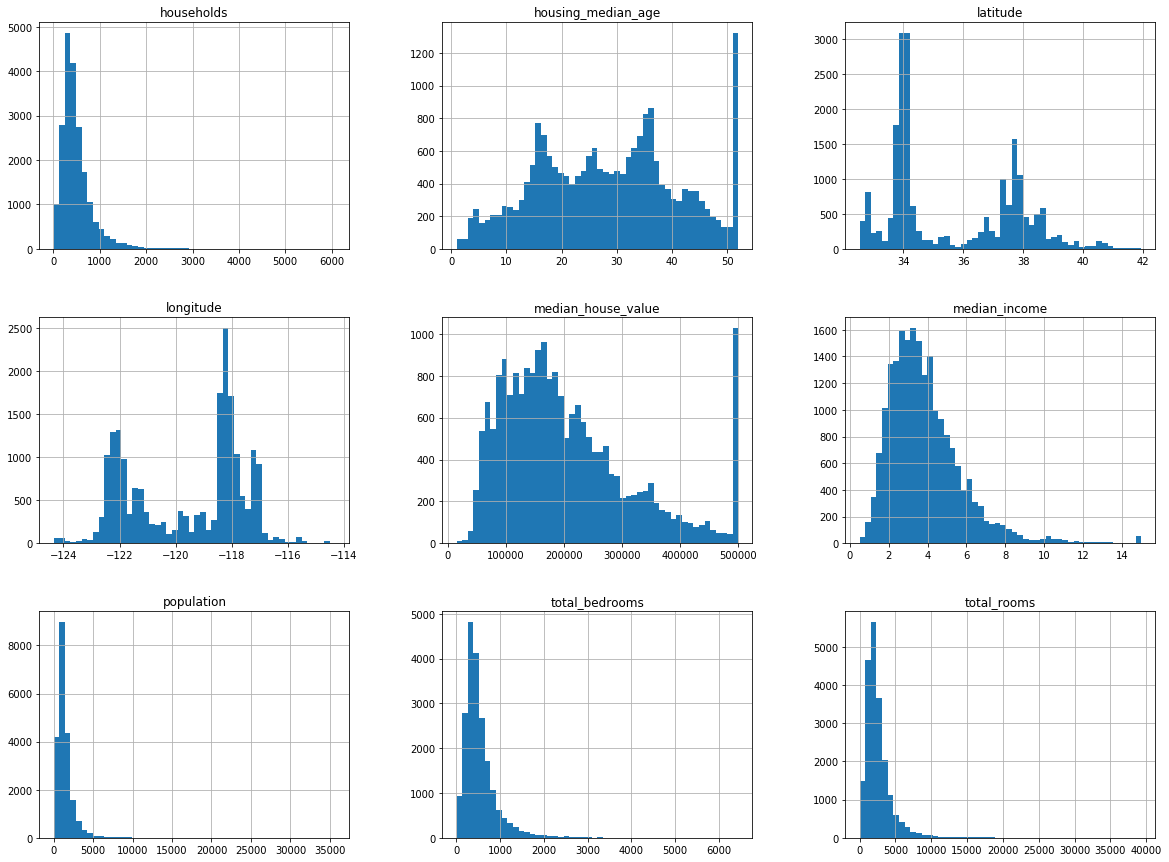

In [7]:
housing.hist(bins=50,figsize=(20,15))
plt.show() #x-axis value, y-axis count

In [8]:
import numpy as np
def split_train_test(data,test_ratio):
    #below sequence will always be different and hence on each iteration different test set will return
    #we have to avoid this
    shuffled_indices = np.random.permutation(len(data))
    test_data_size = int(len(data)*test_ratio)
    test_data_indices = shuffled_indices[:test_data_size]
    train_data_indices = shuffled_indices[test_data_size:]
    train_data = data.iloc[train_data_indices]
    test_data = data.iloc[test_data_indices]
    return test_data,train_data

In [9]:
test_data,train_data = split_train_test(housing,0.2)
print(len(train_data))
print(len(test_data))

16512
4128


In [10]:
from zlib import adler32

def is_test_data_eligible(index,test_ratio):
    return adler32(np.int64(index)) & 0xffffffff < (test_ratio * 2**32)

def split_test_train_by_hashing(data, test_ratio, index_col='id'):
    indices = data[index_col]
    #bool array True means test eligible
    indices = indices.apply(lambda i : is_test_data_eligible(i,test_ratio))
    print(indices)
    return data[indices],data[~indices]

In [11]:
housing["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_test_train_by_hashing(housing, 0.2, "id")
print(len(train_set))
print(len(test_set))

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
         ... 
20610    True
20611    True
20612    True
20613    True
20614    True
20615    True
20616    True
20617    True
20618    True
20619    True
20620    True
20621    True
20622    True
20623    True
20624    True
20625    True
20626    True
20627    True
20628    True
20629    True
20630    True
20631    True
20632    True
20633    True
20634    True
20635    True
20636    True
20637    True
20638    True
20639    True
Name: id, Length: 20640, dtype: bool
20640
0


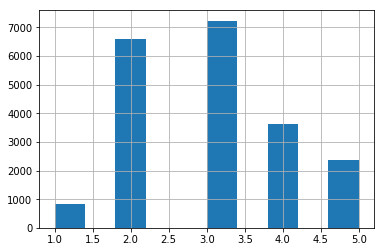

In [12]:
#add a new column income category
#<1.5 cat 1, 1.5-2 cat 2 etc
housing["income_cat"] = pd.cut(housing["median_income"],bins=[0.,1.5,3.0,4.5,6.0,np.inf],labels=[1,2,3,4,5])
housing["income_cat"].hist()

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

In [14]:
#stratified sampling on income category feature
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing,housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
#compare income category distributions on test set and all data
print("income category distribution on test set")
print(strat_test_set["income_cat"].value_counts()/len(strat_test_set))
print("---------------")
print("income category distribution on train set")
print(strat_train_set["income_cat"].value_counts()/len(strat_train_set))

income category distribution on test set
3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64
---------------
income category distribution on train set
3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64


In [16]:
#dropping income_cat attribute from training and test set
for dataset in (strat_test_set,strat_train_set):
    dataset.drop("income_cat",axis=1,inplace=True)

### Discover and Visualize the Data to gain insights

In [17]:
housing = strat_train_set.copy()

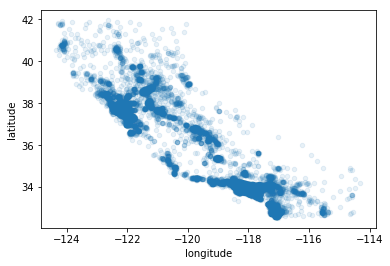

In [18]:
#Understanding the relationship between latitude and longitude
#Shows population density
housing.plot(kind="scatter", x="longitude", y="latitude",alpha=0.1) #alpha is for changing transparency 

### Attributes Combinations

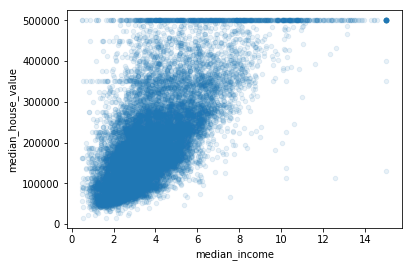

In [19]:
housing.plot(kind='scatter', x='median_income',y='median_house_value',alpha=0.1)
#plot shows correlation between median income and median house value

In [20]:
#combining attributes
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [21]:
#correlatation matrix 
corr_matrix = housing.corr()

In [22]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
id                         -0.047632
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

From above we can see median income is very correlated to median house value. Also new attributes bedrooms_per_room is better in correlation with median house value than total bedrooms.

### Cleaning Data for model

In [23]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### handling missing values

In [24]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [25]:
#only numerical columns
housing_num = housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [26]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,id
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,-121852.71
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,-121892.95
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,-117167.23
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,-119573.69
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,-118555.77


### Handling text and categorical attributes

Convert categorical data into numbers using OrdinalEncoder

In [32]:
housing_cat = housing[["ocean_proximity"]]  #df
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [33]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [34]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

### Feature Scaling

#### MinMax Scaling

- Subtract all values from min then divide by (max-min)
- all the values is rescaled to [0-1]

#### Standardization
- Subtract values by mean. Mean of new distribution is zero
- divide by standard deviation
- doesn't bound input values to specific range as in MinMaxScaling
- Less affected to outliers. (how? as we are not using min or max for Scaling as in MinMax scaling)

### Creating single sklearn pipeline for data preprocessing